/home/imalsky/Desktop/spectra/Spec_0_UPS-LOW-G-CLEAR-250_phase_0.0_inc_0.0000.00.dat
/home/imalsky/Desktop/spectra/Spec_0_UPS-LOW-G-CLEAR-250_phase_135.0_inc_0.0000.00.dat
/home/imalsky/Desktop/spectra/Spec_0_UPS-LOW-G-CLEAR-250_phase_180.0_inc_0.0000.00.dat
/home/imalsky/Desktop/spectra/Spec_0_UPS-LOW-G-CLEAR-250_phase_225.0_inc_0.0000.00.dat
/home/imalsky/Desktop/spectra/Spec_0_UPS-LOW-G-CLEAR-250_phase_270.0_inc_0.0000.00.dat
/home/imalsky/Desktop/spectra/Spec_0_UPS-LOW-G-CLEAR-250_phase_315.0_inc_0.0000.00.dat
/home/imalsky/Desktop/spectra/Spec_0_UPS-LOW-G-CLEAR-250_phase_45.0_inc_0.0000.00.dat
/home/imalsky/Desktop/spectra/Spec_0_UPS-LOW-G-CLEAR-250_phase_90.0_inc_0.0000.00.dat
/home/imalsky/Desktop/spectra/Spec_0_UPS-LOW-G-CLOUDY-250_phase_0.0_inc_0.0000.00.dat
/home/imalsky/Desktop/spectra/Spec_0_UPS-LOW-G-CLOUDY-250_phase_135.0_inc_0.0000.00.dat
/home/imalsky/Desktop/spectra/Spec_0_UPS-LOW-G-CLOUDY-250_phase_180.0_inc_0.0000.00.dat
/home/imalsky/Desktop/spectra/Spec_0_UPS-LOW-G

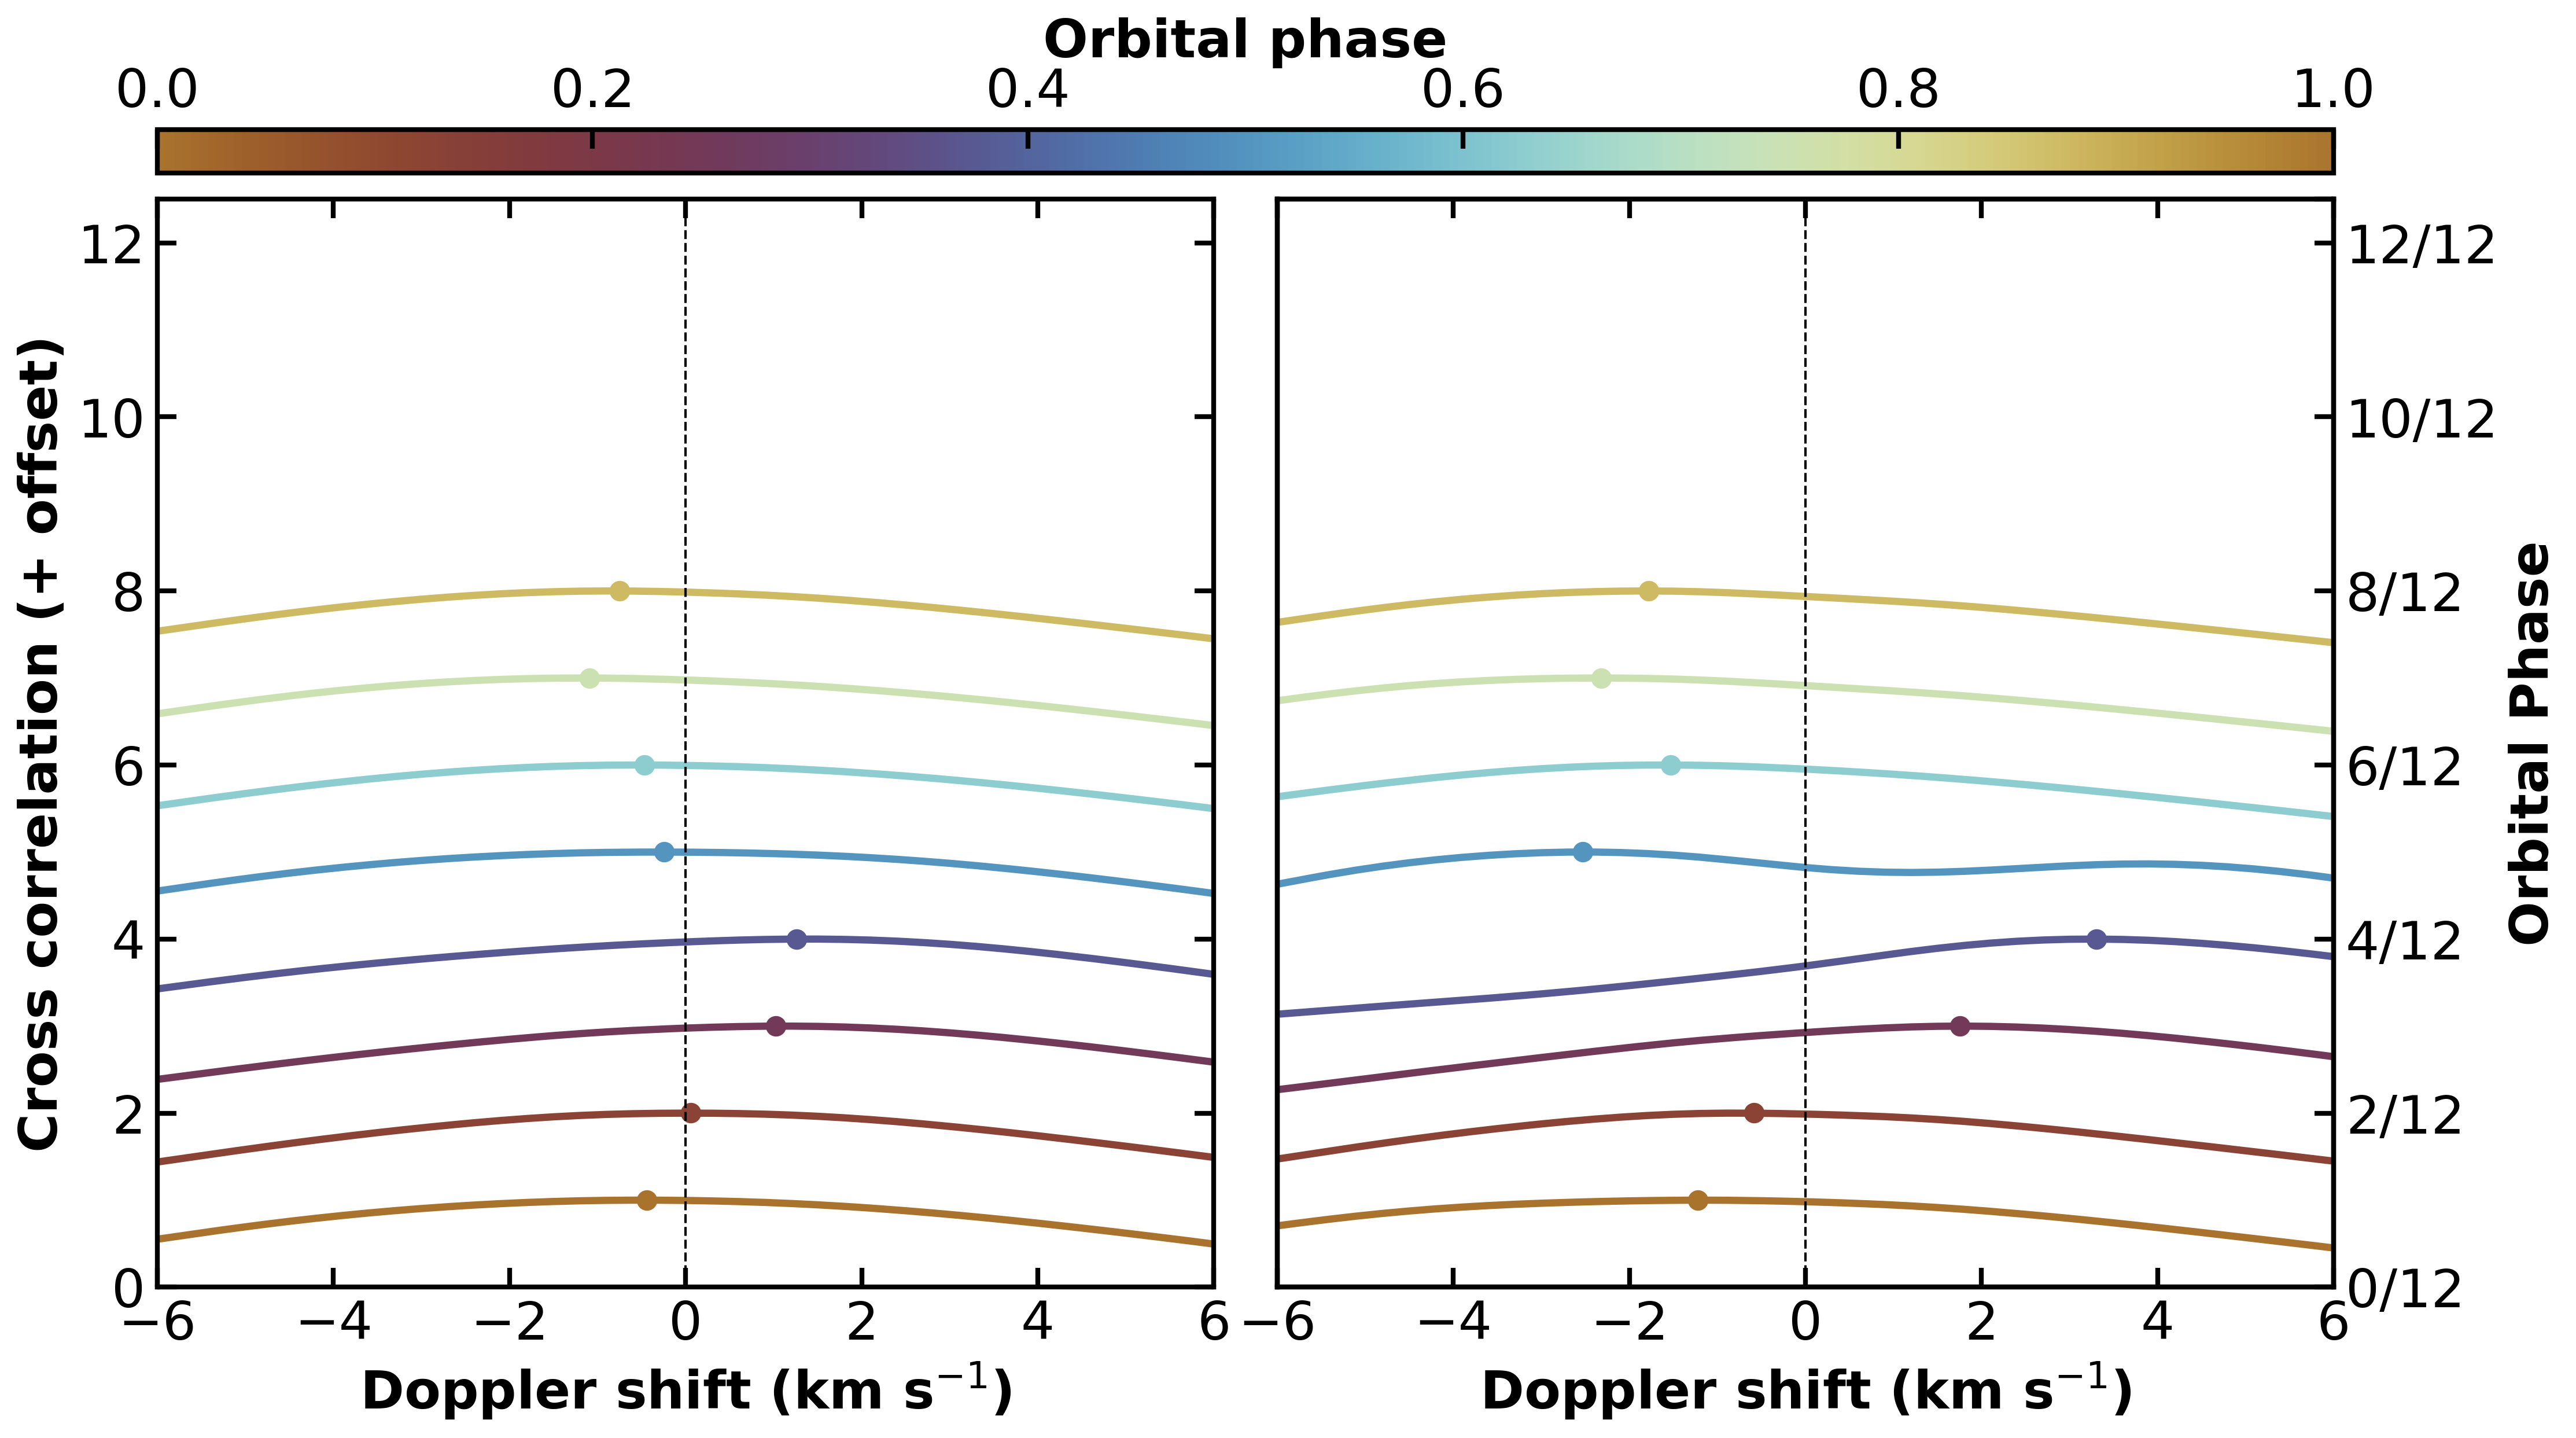

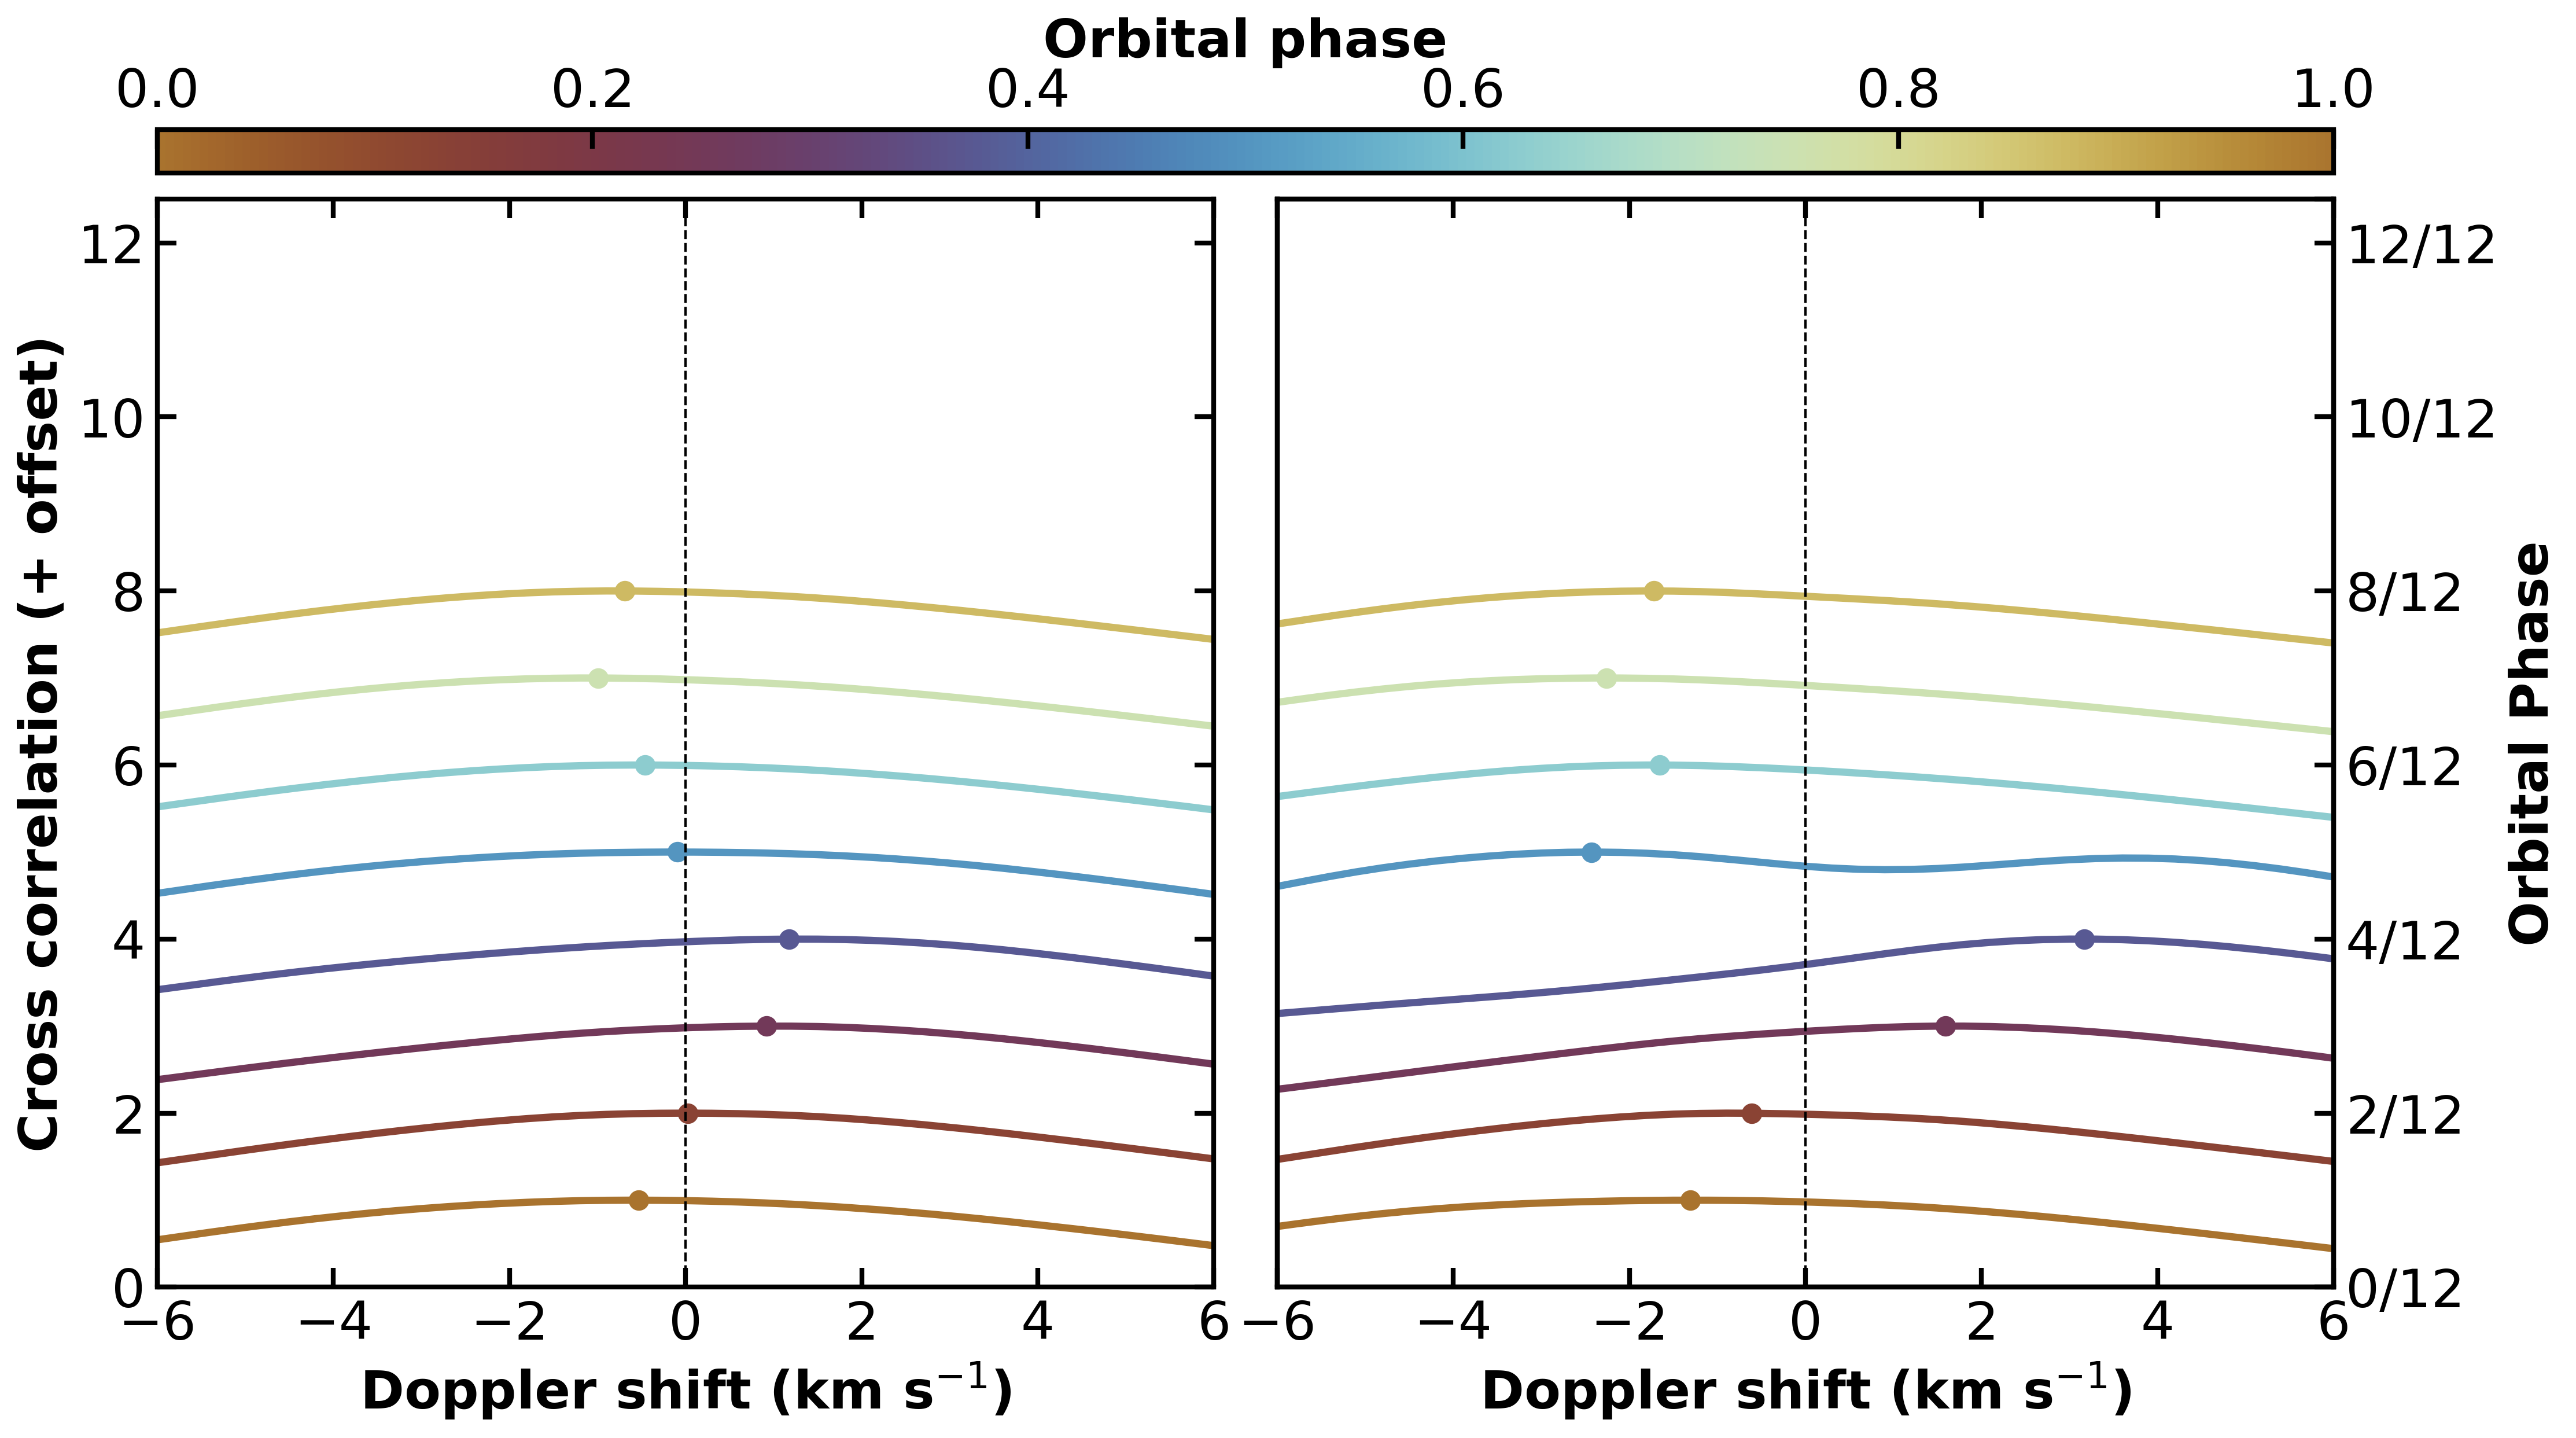

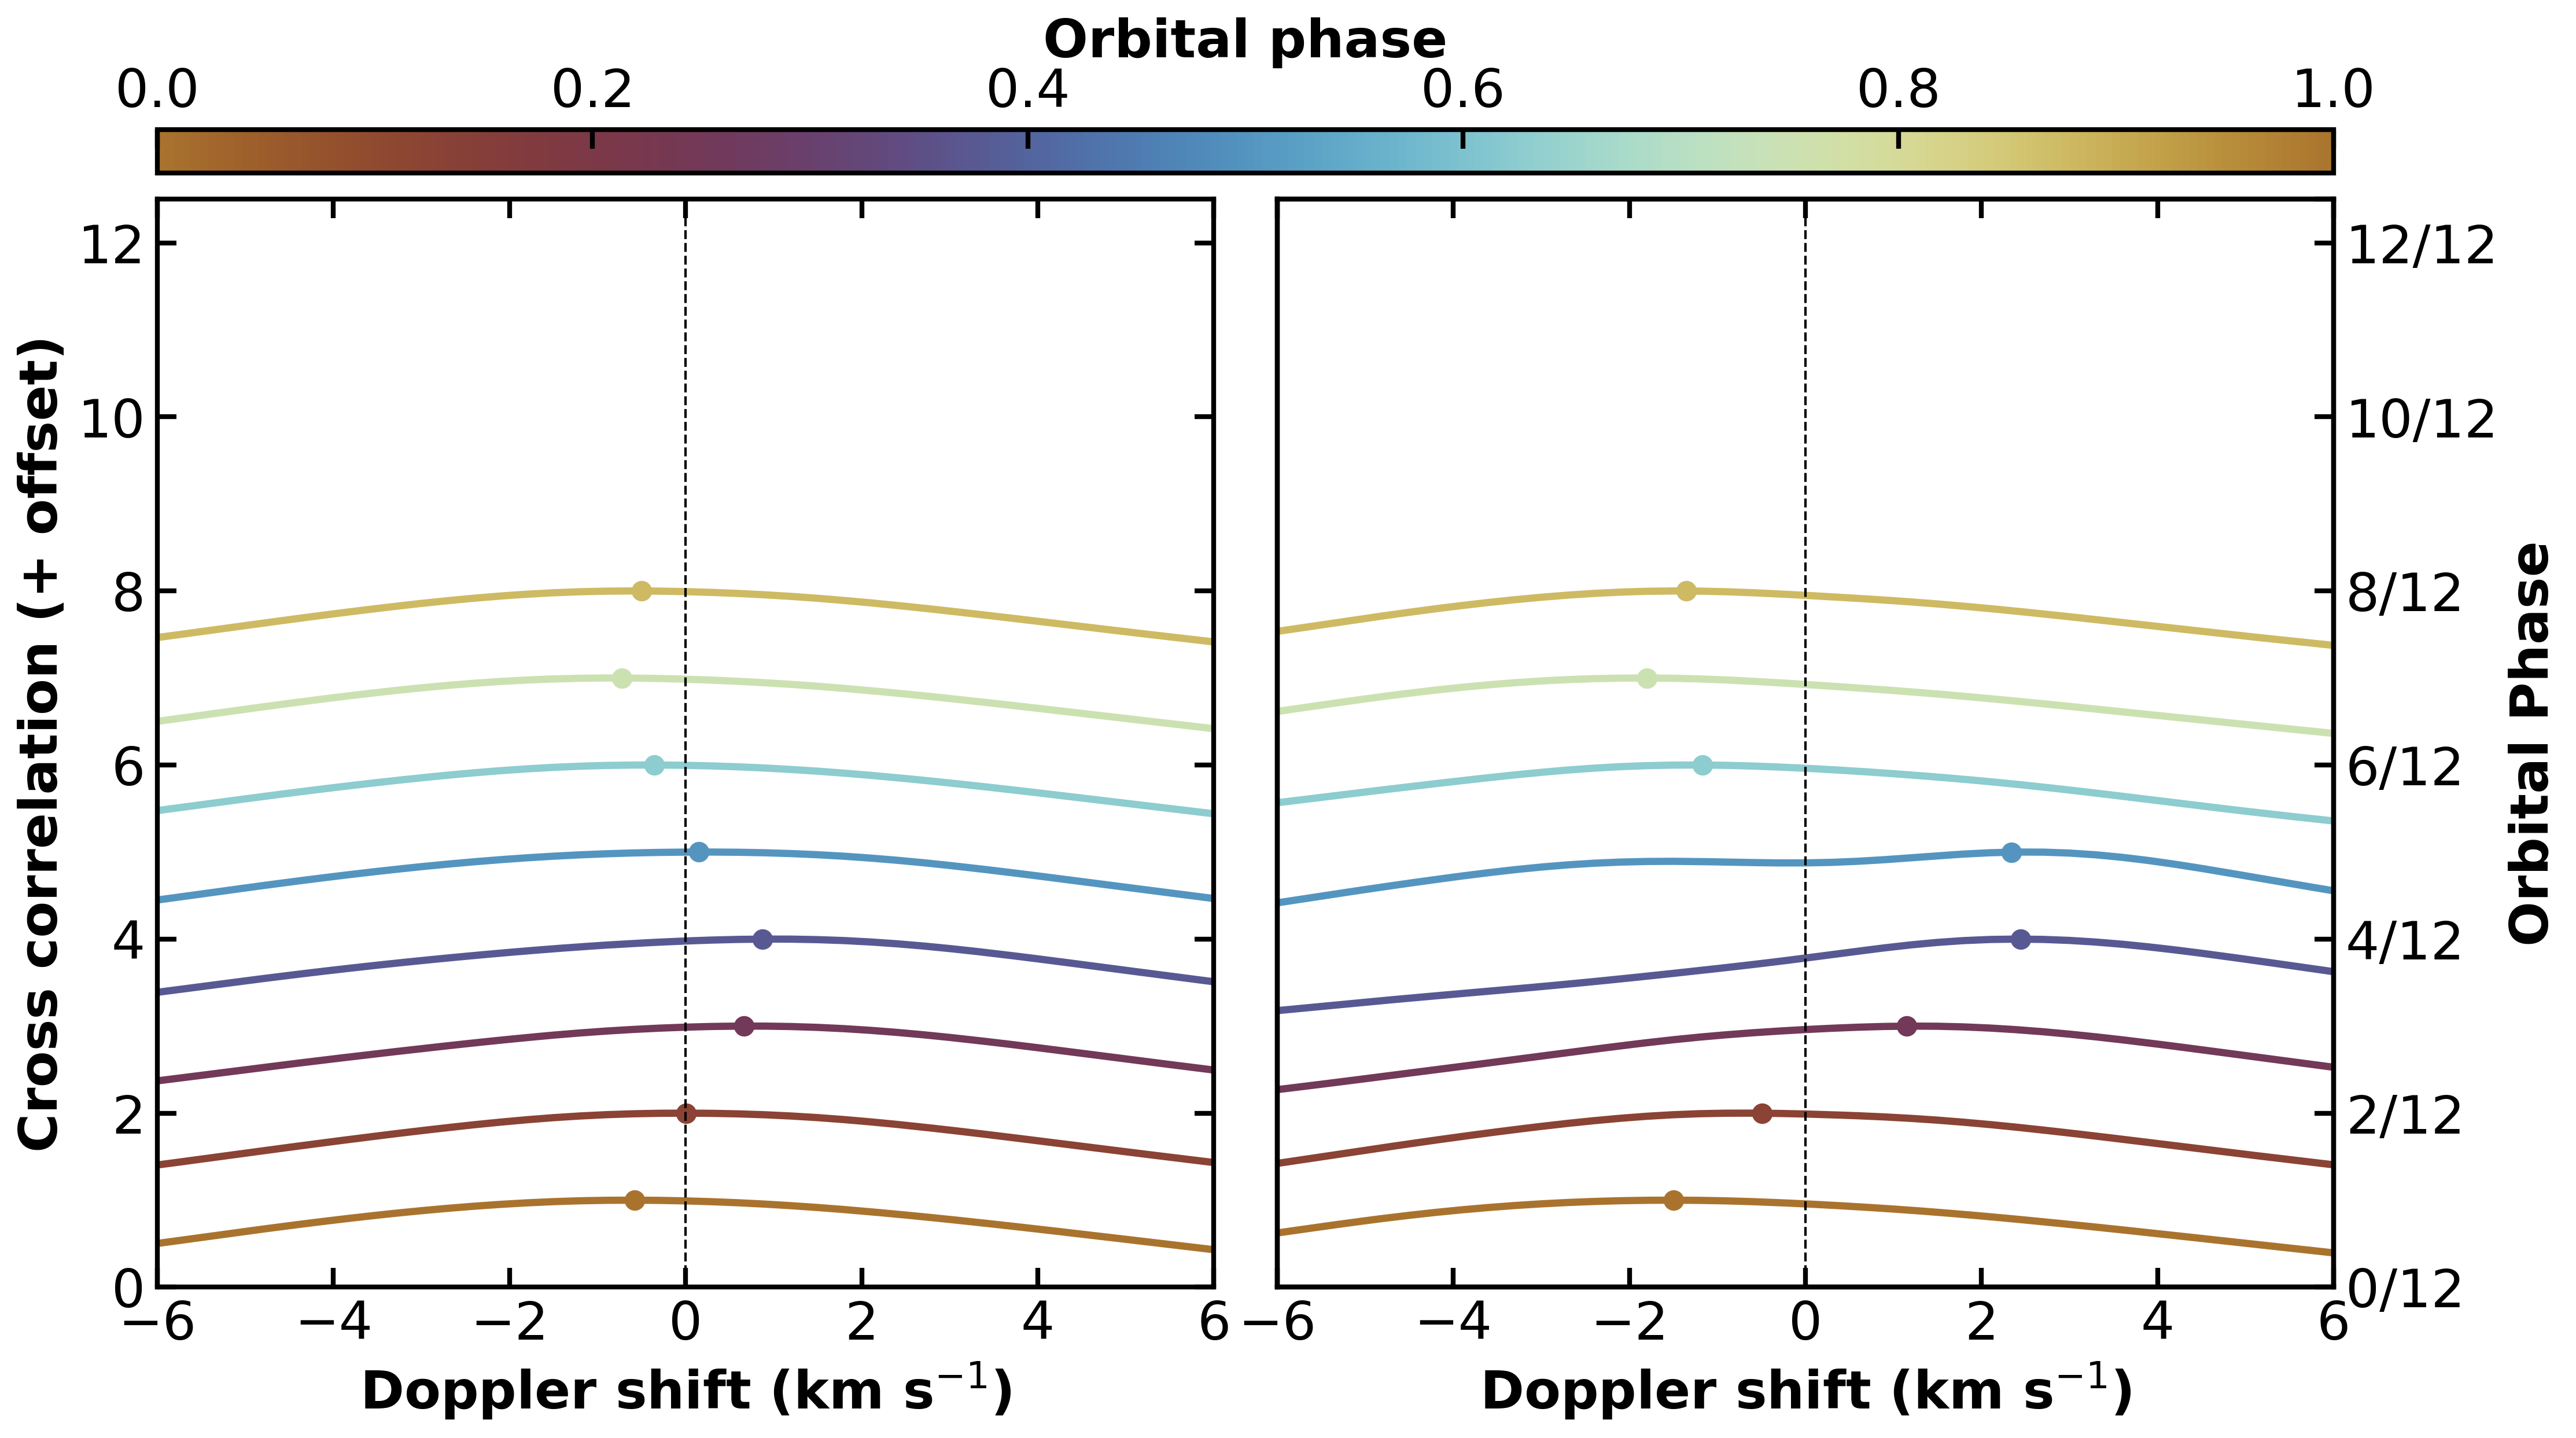

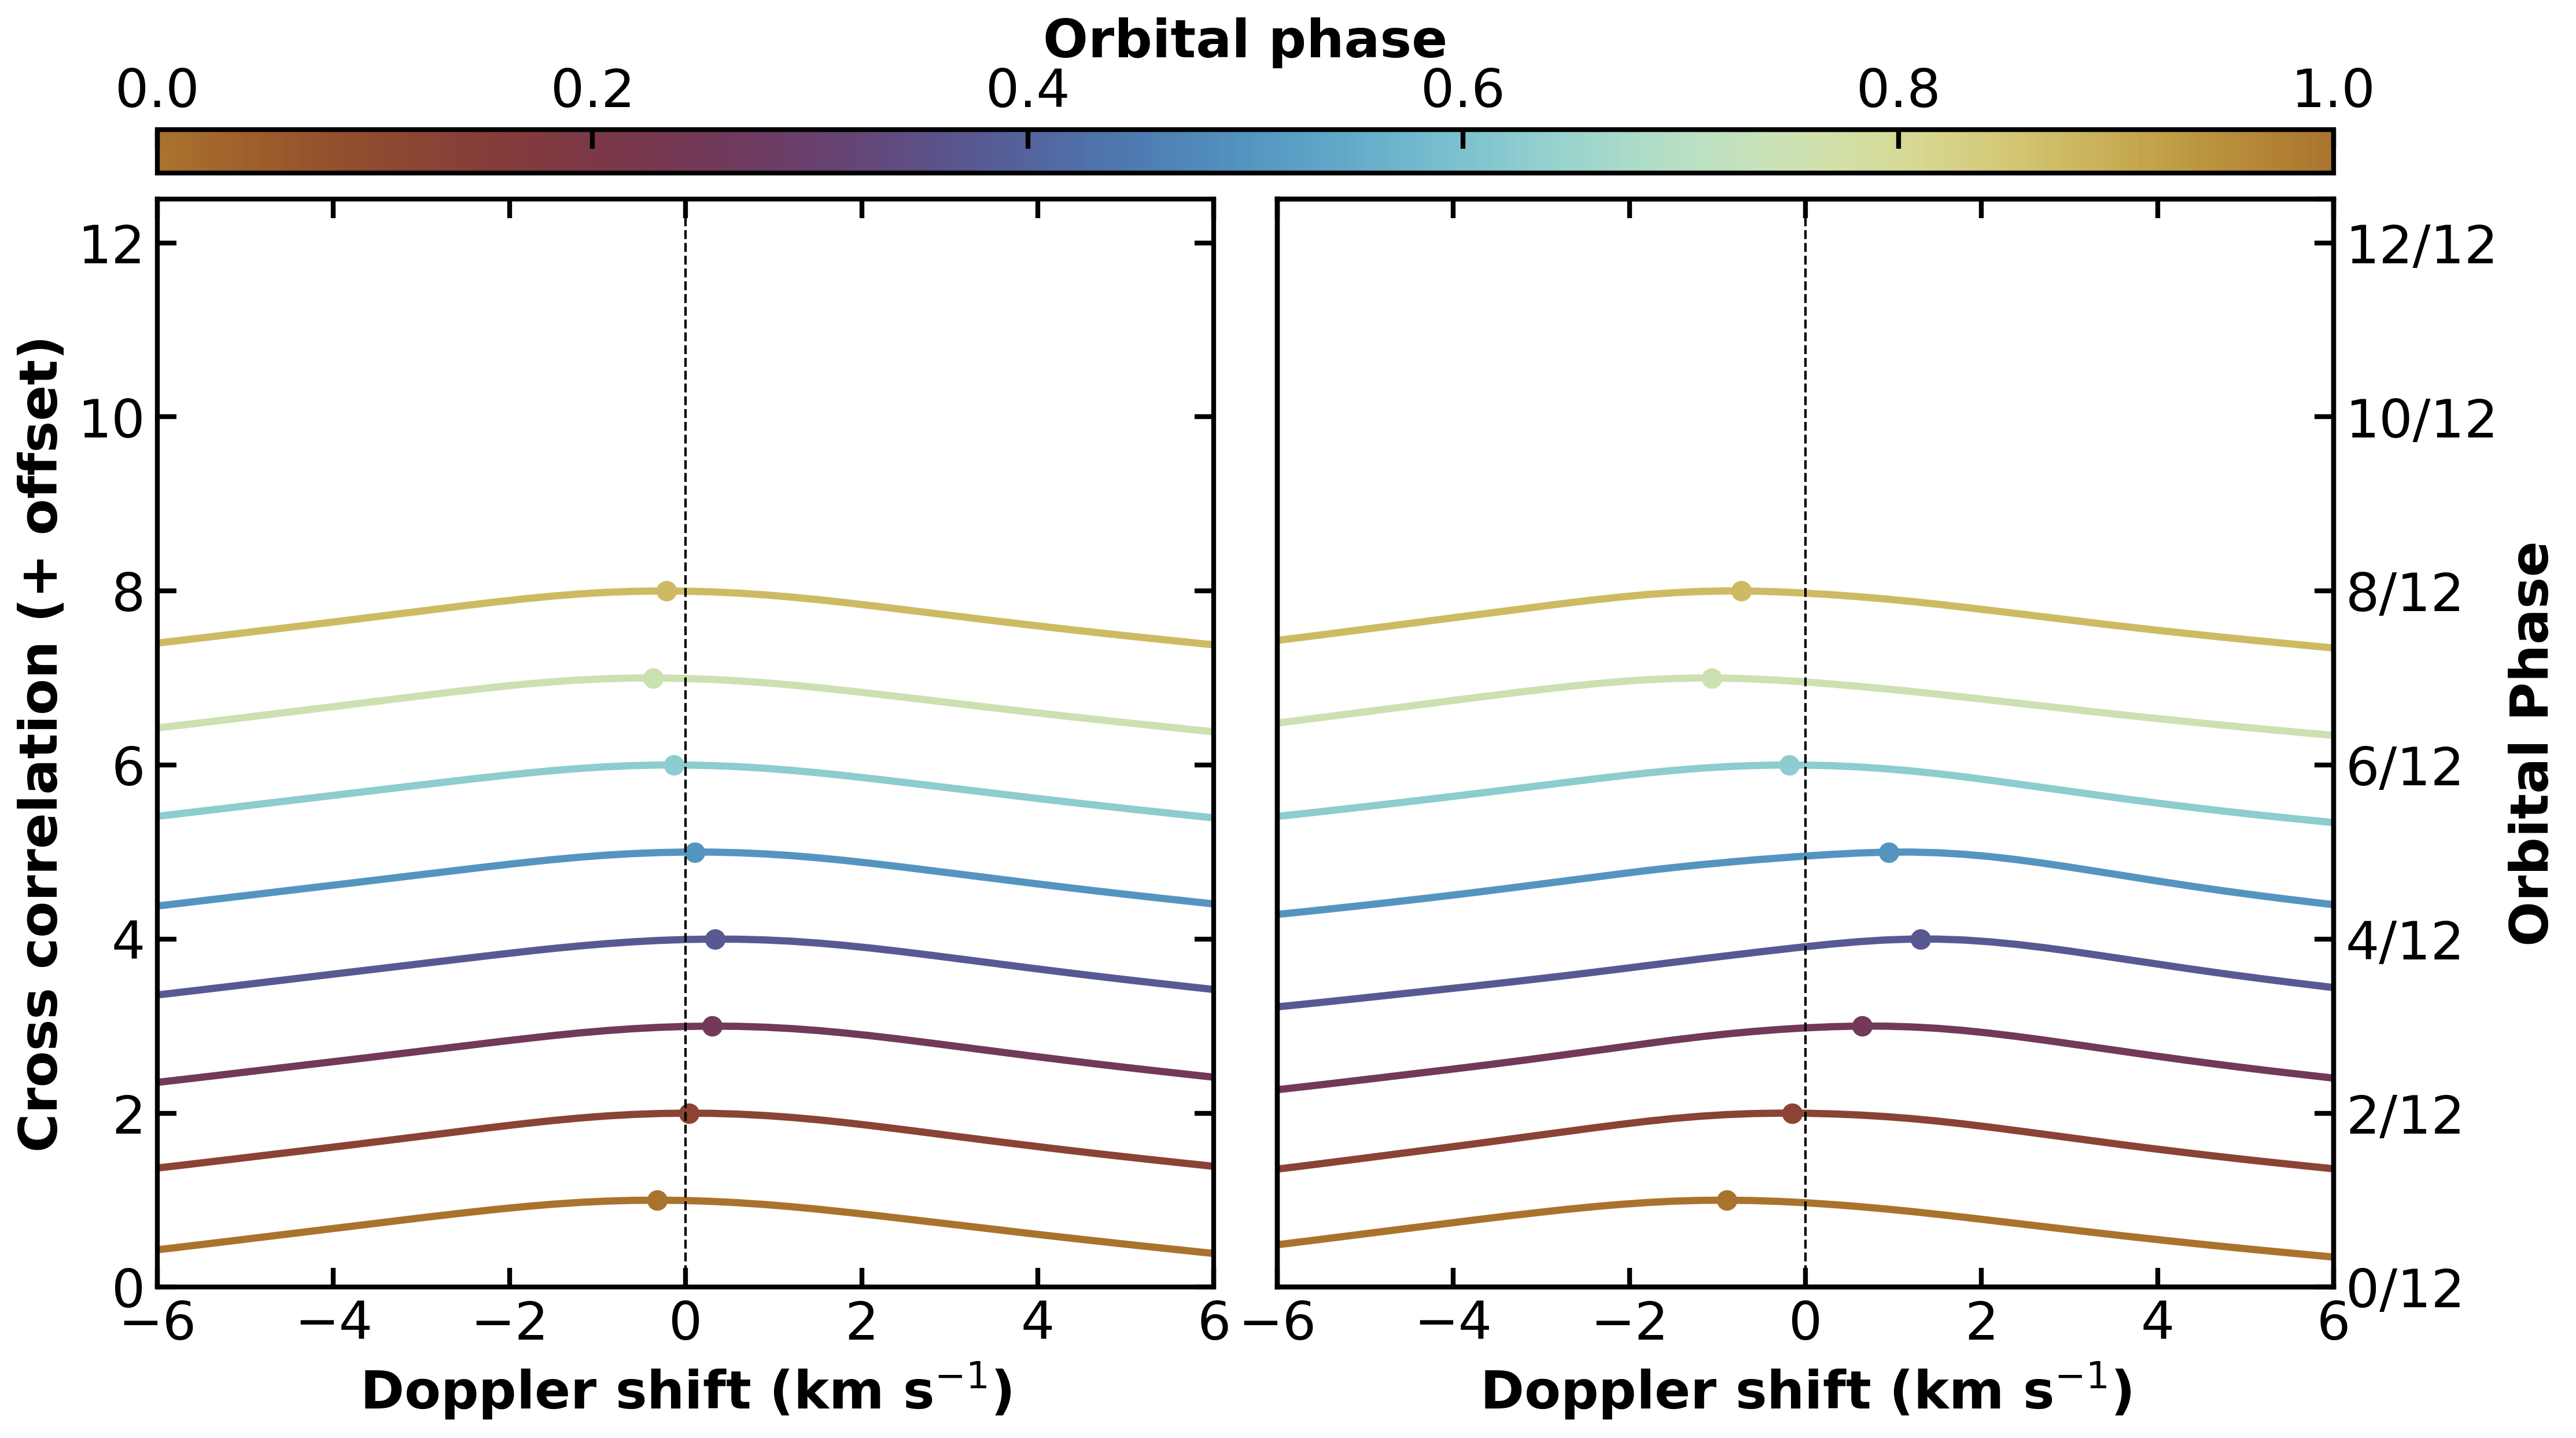

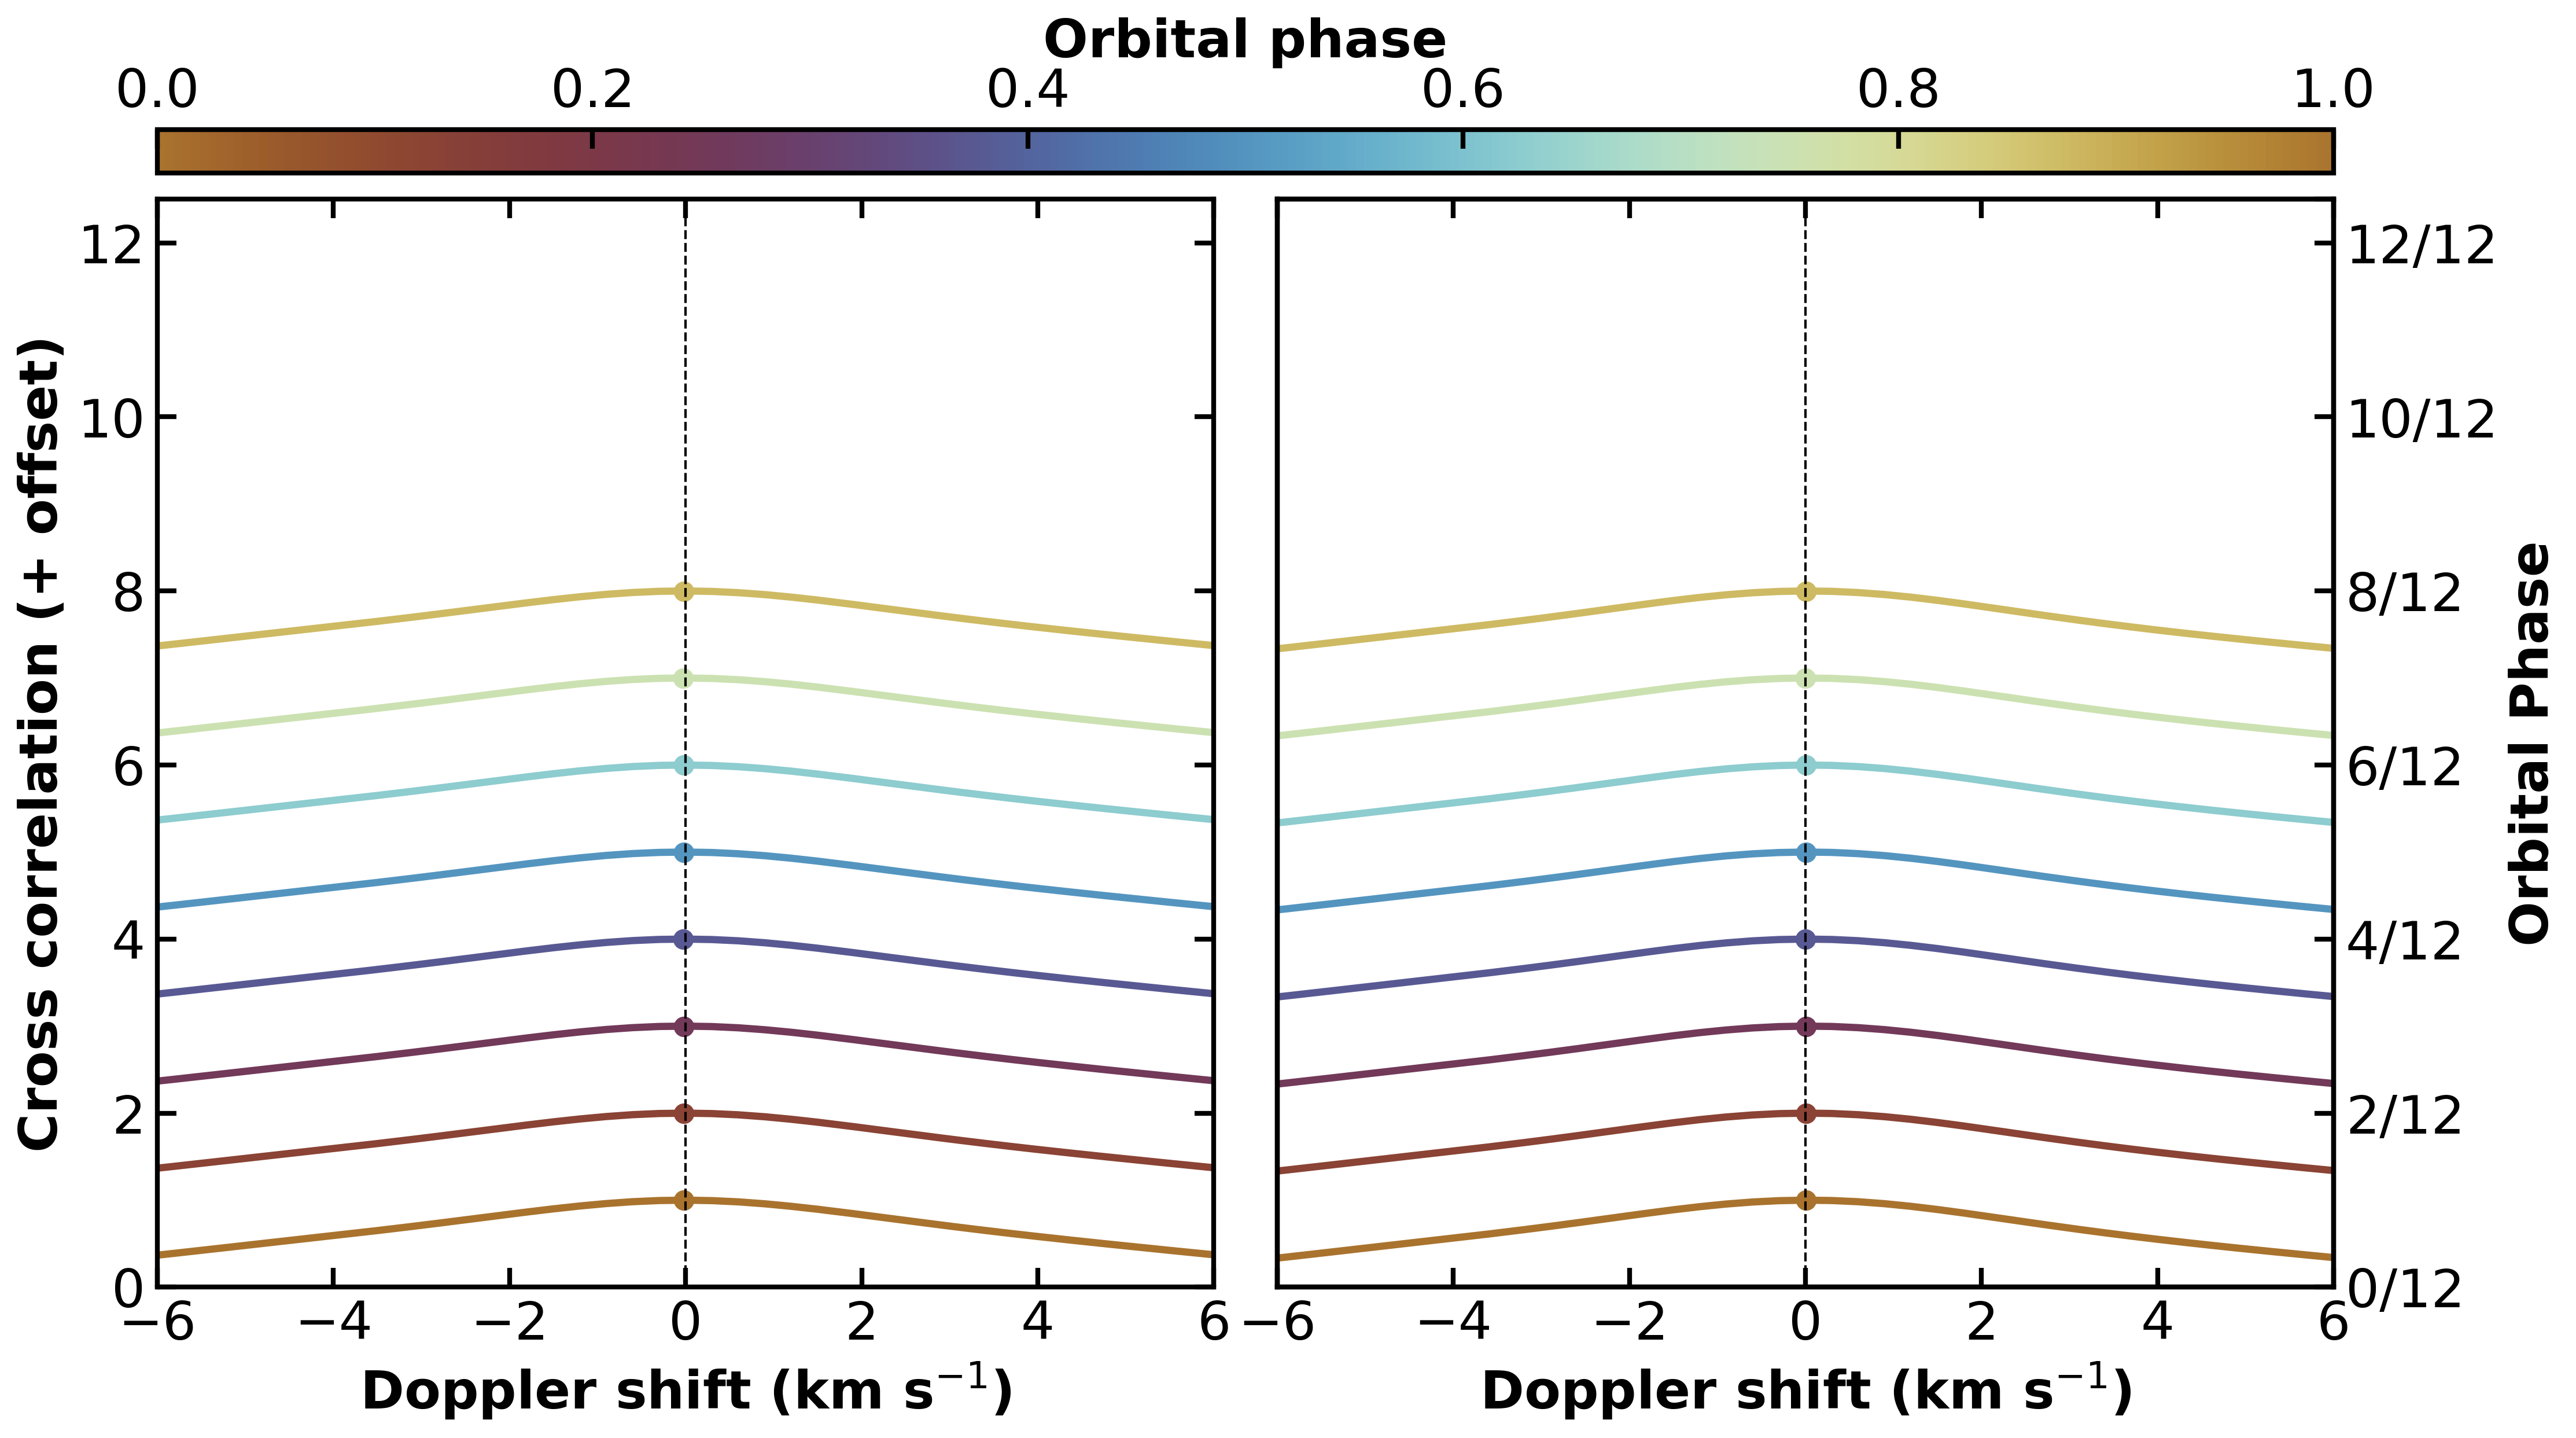

In [34]:
'''

Caleb Harada

plot CCFs for multiple phases and overplot RV as a function of phase


'''


import numpy as np
from PyAstronomy import pyasl
from scipy.optimize import curve_fit
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import glob
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.ticker import MaxNLocator

plt.style.use('/home/imalsky/Desktop/isaac-style.txt')




### ----- INPUT/OUTPUT ----- ###

savefile = '/home/imalsky/Desktop/ccfs.png'


list1 = ['0.0', '0.39269908', '0.78539816','1.17809725','1.57079633']
list2 = ['0.0', '0.393', '0.785', '1.178', '1.5708']


#list1 = ['1.152']
#list2 = ['1.152']


data_dict = {}


### ----- GET FILES ----- ###
for z in range(len(list1)):   
    clear_files_dopp = '/home/imalsky/Desktop/spectra/Spec_1_UPS-LOW-G-CLEAR-250_phase_*_inc_{}000.00.dat'.format(list1[z])
    clear_files_rest = '/home/imalsky/Desktop/spectra/Spec_0_UPS-LOW-G-CLEAR-250_phase_*_inc_{}000.00.dat'.format(list1[z])

    extended_thick_files_dopp = '/home/imalsky/Desktop/spectra/Spec_1_UPS-LOW-G-CLOUDY-250_phase_*_inc_{}000.00.dat'.format(list2[z])
    extended_thick_files_rest = '/home/imalsky/Desktop/spectra/Spec_0_UPS-LOW-G-CLOUDY-250_phase_*_inc_{}000.00.dat'.format(list2[z])

    # set up CCF figure
    font = {'size' : 16, 'family' : 'sans-serif'}
    plt.rc('font', **font)

    fig, axes = plt.subplots(1, 2, figsize=(16.18, 10))
    plt.subplots_adjust(wspace=0.06, hspace=0)


    #phases = [0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0, 240.0, 270.0, 300.0, 330.0]
    phases = [0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0]

    # colormap
    cm_name = 'romaO'
    cm_file = np.loadtxt(f'/home/imalsky/Desktop/New_Jups/Code/ScientificColourMaps6/{cm_name}/{cm_name}-64.txt')
    my_colors = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file[::-1])
    colors = np.linspace(0, 256, len(phases) + 1)


    def dopp_signatures(templates, signals, axis, phase_fmt='int'):

        ### ----- LOAD DATA ----- ###

        templates = sorted(glob.glob(templates))
        signals = sorted(glob.glob(signals))

        RVs = np.zeros(len(templates) + 1)

        axis.set_xlim([-5, 5])
        axis.set_ylim([0, 12.5])


        # keep track of color and offset
        color_idx = 0
        offset = 0

        for i in range(len(templates)):
            color_val = int(colors[i])
        
            print (templates[i])
            tw, tf = np.loadtxt(templates[i], unpack=True)
            dw, df = np.loadtxt(signals[i], unpack=True)

            # Carry out the cross-correlation.
            # The RV-range is -10 to +10 km/s in steps of 0.1 km/s.
            # The first and last 200 points of the data are skipped.
            rv, cc = pyasl.crosscorrRV(dw, df, tw, tf, -10., 10., 0.1, skipedge=500)

            # normalize cc function 
            cc = (cc - min(cc)) / (max(cc) - min(cc))

            # Find the index of maximum cross-correlation function
            maxind = np.argmax(cc)


            # define Gaussian function
            def gaussian(x, a, x0, sigma):
                return a * np.exp(-(x - x0) * (x - x0) / (2 * sigma * sigma))


            # fit Guassian to peak region of cc function
            rv_range = rv[maxind - 20: maxind + 20]
            cc_range = cc[maxind - 20: maxind + 20]

            popt, pcov = curve_fit(gaussian, rv_range, cc_range, p0=[1, 0, 1])

            # calculate best fit guassian
            rv_fit = np.linspace(rv[maxind - 20], rv[maxind + 20], 1000)
            cc_fit = gaussian(rv_fit, *popt)

            # index of maximum of Gaussian
            max_gauss = np.argmax(cc_fit)

            # save radial velocity
            RVs[i] = rv_fit[max_gauss]

            # plot CCFs
            axis.plot(rv, cc + offset, lw=3, color=my_colors(color_val))
            axis.plot(rv_fit[max_gauss], cc_fit[max_gauss] + offset, '.', ms=15, color=my_colors(color_val))
            data_dict[phases[i]] = rv_fit[max_gauss]


            offset += 1
            color_idx += 1

        return RVs, phases




    clear_RVs, clear_phases = dopp_signatures(clear_files_rest, clear_files_dopp, axes[0], phase_fmt='float')
    
    #print(list(data_dict.values()))

    cloudy_RVs, cloudy_phases = dopp_signatures(extended_thick_files_rest,
                                                extended_thick_files_dopp, axes[1], phase_fmt='float')
    
    #print(list(data_dict.values()))
    #print ()


    cloudy_ax = axes[1].twinx()
    x_ticks_labels = ['0/12', '2/12', '4/12', '6/12', '8/12', '10/12', '12/12']


    axes[1].yaxis.set_ticks([])
    cloudy_ax.set_yticks([0, 2, 4, 6, 8, 10, 12, 12.5])
    cloudy_ax.set_yticklabels(x_ticks_labels)
    
    axes[0].xaxis.set_ticks([-6, -4, -2, 0, 2, 4, 6])
    axes[1].xaxis.set_ticks([-6, -4, -2, 0, 2, 4, 6])


    axes[0].set_xlabel('Doppler shift (km s$^{-1}$)',fontsize=22, weight='bold')
    axes[1].set_xlabel('Doppler shift (km s$^{-1}$)',fontsize=22, weight='bold')
    axes[0].set_ylabel('Cross correlation (+ offset)',fontsize=22, weight='bold')

    cloudy_ax.set_ylabel('Orbital Phase',fontsize=22, weight='bold')

    axes[0].axvline(linewidth=1, color='k',linestyle='dashed')
    axes[1].axvline(linewidth=1, color='k',linestyle='dashed')

    my_colors = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file[::-1])

    sm = plt.cm.ScalarMappable(cmap=my_colors, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []
    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), location='top', aspect=50, pad=0.02)
    cbar.set_label('Orbital phase', fontsize=22, weight='bold')

    fig.savefig(savefile, bbox_inches='tight', dpi=300)

    


In [6]:
ups_clear = [-0.27097097097083256, 0.01501501501515734, 0.2149149149150601, 0.39709709709724494, 0.47687687687702585, 0.3830830830832308, 0.1868868868870317, -0.3310310310308936, -0.005005005004862895, -0.15485485485471484, -0.2849849849848469, -0.15885885885871898]
ups_cloudy = [-0.7868868868867558, -0.2529529529528143, 0.2029029029030479, 0.7331331331332858, 1.2330330330331927, 1.4529529529531158, 1.1089089089090667, -0.9870870870869589, 0.20090090090104595, -0.3430430430429058, -0.8849849849848554, -0.6150150150148815]

clear_1 = [-0.254, 0.21, 1.082, 1.31, -0.038, -0.314, -0.878, -0.538]
clear_2 = [-0.378, 0.166, 1.01, 1.286, 0.094, -0.338, -0.814, -0.51]
clear_3 = [-0.546, 0.118, 0.846, 1.126, 0.326, -0.326, -0.694, -0.434]
clear_4 = [-0.466, 0.162, 0.622, 0.742, 0.31, -0.166, -0.554, -0.29]
clear_5 = [0.03, 0.03, 0.03, 0.026, 0.026, 0.03, 0.026, 0.026]

cloudy_1 = [-3.282, -0.554, 2.422, 4.634, 1.706, 6.122, -2.682, -2.422]
cloudy_2 = [-3.058, -0.59, 2.214, 4.21, 1.582, 2.546, -2.986, -2.51]
cloudy_3 = [-1.37, -0.646, 1.838, 0.358, 0.826, 0.698, -2.878, -2.118]
cloudy_4 = [-0.022, -0.186, 1.65, -1.058, -0.23, -0.174, 0.854, -1.586]
cloudy_5 = [-0.21, -0.238, -0.23, -0.234, -0.226, -0.15, -0.106, -0.246]


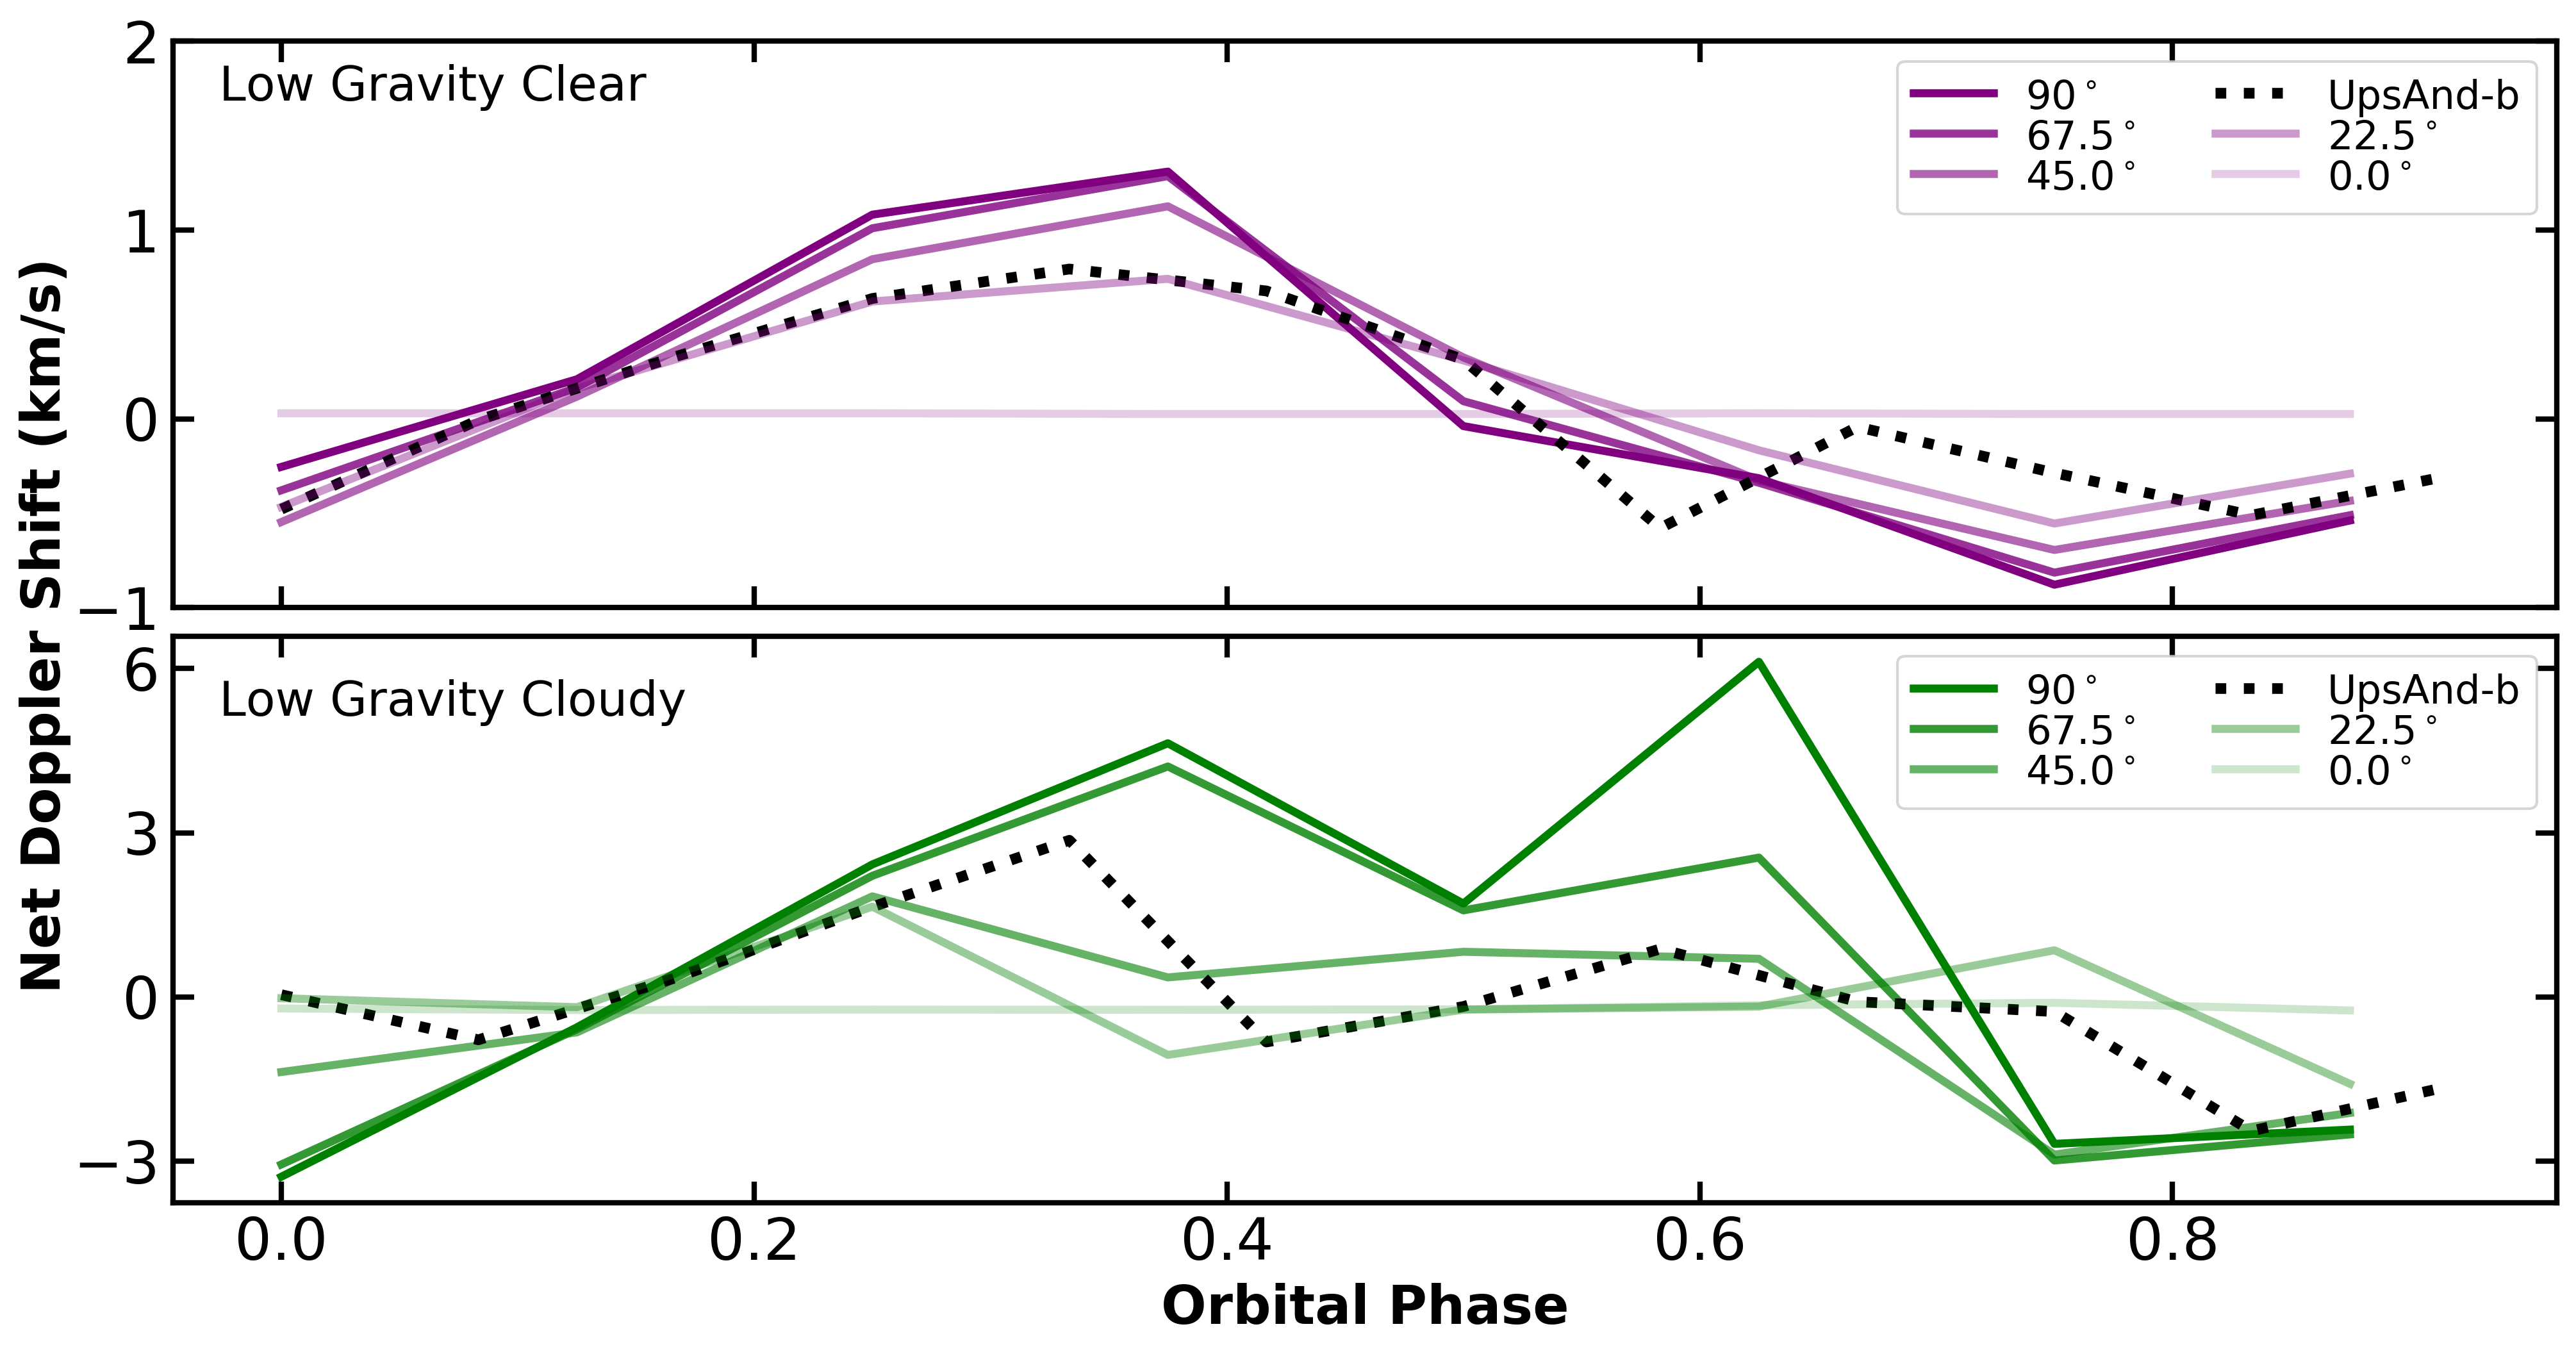

In [62]:

fig, ax = plt.subplots(2,1, sharey=False, sharex=True, figsize=(16,8))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
from scipy.interpolate import interp1d
plt.style.use('/home/imalsky/Desktop/isaac-style.txt')

phases = [0.0, 30.0, 60.0, 90.0, 120.0, 150.0,
          180.0, 210.0, 240.0, 270.0, 300.0, 330.0]

phases2 = [0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0]

phases = np.asarray(phases) / 360
phases2 = np.asarray(phases2) / 360


ax[0].plot(phases2, clear_1, color='purple', alpha=1.0, linewidth=3, label=r'90$^\circ$')
ax[0].plot(phases2, clear_2, color='purple', alpha=0.8, linewidth=3, label=r'67.5$^\circ$')
ax[0].plot(phases2, clear_3, color='purple', alpha=0.6, linewidth=3, label=r'45.0$^\circ$')
ax[0].plot(phases, ups_clear, color='black', linestyle='dotted', linewidth=4, label=r'UpsAnd-b')
ax[0].plot(phases2, clear_4, color='purple', alpha=0.4, linewidth=3, label=r'22.5$^\circ$')
ax[0].plot(phases2, clear_5, color='purple', alpha=0.2, linewidth=3, label=r'0.0$^\circ$')

#ax[0].set_ylabel('Net Doppler Shift [km/s]', fontsize=18, weight='bold')
#ax[0].set_xlabel('Orbital Phase', fontsize=18, weight='bold')
ax[0].legend(fontsize=15, ncol=2, handleheight=1, labelspacing=0.01, loc='upper right')


ax[1].plot(phases2, cloudy_1, color='green', alpha=1.0, linewidth=3, label=r'90$^\circ$')
ax[1].plot(phases2, cloudy_2, color='green', alpha=0.8, linewidth=3, label=r'67.5$^\circ$')
ax[1].plot(phases2, cloudy_3, color='green', alpha=0.6, linewidth=3, label=r'45.0$^\circ$')
ax[1].plot(phases, ups_cloudy, color='black', linestyle='dotted', linewidth=4, label=r'UpsAnd-b')
ax[1].plot(phases2, cloudy_4, color='green', alpha=0.4, linewidth=3, label=r'22.5$^\circ$')
ax[1].plot(phases2, cloudy_5, color='green', alpha=0.2, linewidth=3, label=r'0.0$^\circ$')


ax[1].set_xlabel('Orbital Phase', fontsize=20, weight='bold')
ax[1].legend(fontsize=15, ncol=2, handleheight=1, labelspacing=0.01, loc='upper right')


ax[0].set_yticks([-1.0, 0.0, 1.0, 2.0])
ax[1].set_yticks([-3.0, 0.0, 3.0, 6.0])

fig.text(0.14, 0.85, r"Low Gravity Clear", size=18, weight='normal', va='center')
fig.text(0.14, 0.45, r"Low Gravity Cloudy", size=18, weight='normal', va='center')


fig.text(0.075, 0.5, r"Net Doppler Shift (km/s)", size=20, weight='bold', va='center', rotation='vertical')

plt.savefig('/home/imalsky/Desktop/net-dopplers.png', bbox_inches='tight', dpi=200)

In [13]:
#Clear
list1 = [5.512859008990926, 4.793589923906564, 4.7469994250905785, 
4.7693097817975705,  6.05344062318486,  5.368045041673466, 
5.3812421868486675, 5.007733529946819]

list2 = [3.158389507066457, 3.158576346745017, 3.1585533005516817,  3.1577041636606245, 
3.1576251908598927,  3.158333153603284, 3.1577370319050697,  3.157821637393597]

#Cloudy
list3 = [3.6778393966788046, 4.430502168705506, 4.277180199389904, 4.164554184016851,
2.71058656635932, 3.186890878656664,  6.927803014440564, 4.830222202338542]

list4 = [1.9756118098352633, 2.0189216171408444, 1.9776401343446357, 2.0143353405684308,
2.0043683583343608, 1.972630199277207,  1.9562105869920643, 2.0350688074457333]



print (np.mean(list1), np.mean(list2), np.mean(list3), np.mean(list4))


5.204152440179931 3.158092541473203 4.27569732632327 1.9943483567423175


In [ ]:
            # define Gaussian function
            def gaussian(x, a, x0, sigma):
                return a * np.exp(-(x - x0) * (x - x0) / (2 * sigma * sigma))


            # fit Guassian to peak region of cc function
            rv_range = rv[maxind - 20: maxind + 20]
            cc_range = cc[maxind - 20: maxind + 20]

            popt, pcov = curve_fit(gaussian, rv_range, cc_range, p0=[1, 0, 1])

            # calculate best fit guassian
            rv_fit = np.linspace(rv[maxind - 20], rv[maxind + 20], 1000)
            cc_fit = gaussian(rv_fit, *popt)

            # index of maximum of Gaussian
            max_gauss = np.argmax(cc_fit)

            # save radial velocity
            RVs[i] = rv_fit[max_gauss]

            # plot CCFs
            axis.plot(rv, cc + offset, lw=3, color=my_colors(color_val))
            axis.plot(rv_fit[max_gauss], cc_fit[max_gauss] + offset, '.', ms=15, color=my_colors(color_val))
            data_dict[phases[i]] = rv_fit[max_gauss]